# Learn simple layer of RNN


RNN_model8 uses one layer of recurrent units.
Dataset can be downloaded in http://www.montefiore.ulg.ac.be/services/acous/STSI/downloads.php

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
from saveTransformedGraph import optimizeGraph
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *
from keras.layers import SimpleRNN


modelName = "RNN1"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = 0
num_step = 150                                       # number of time steps before reduction
conv_chan = [35]                                     # number of kerneld for convolution
conv_strides = 3                                     # delay between two convolution
conv_size = 12                                       # filter size for the convolution
size_poll = 4
reg_scale = 0
l1l2Prop = 0.4  # 1 =>l1, 0=> l2
reg_scale_l1 = l1l2Prop*reg_scale
reg_scale_l2 = ((1-l1l2Prop)/2)*reg_scale
num_hidden = 150                                     # number of hidden units
num_out = 1                                          # size of the output
num_feature = 1                                      # size of the input
batch_size = 2500                                  
n_layer = 1                                             

#num_hidden = num_hidden/keep_prob
num_epoch = 10000                                      
trainDuration = 60*60*15                             
amplifierName = 'EnglDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat' # dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat'      # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)


print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")

#######################
# Graph Construction
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") 
        target = tf.placeholder(tf.float32, [None, num_out],name = "target") 

    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,1,1]) 
    with tf.variable_scope("ConvLayers"):
        regularizerC1 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC1")
        dataReduced = tf.layers.conv2d(inputs = dataShaped,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(4,1),
                                       padding = "same",activation=tf.nn.elu,kernel_regularizer=regularizerC1,name="C1")
        regularizerC2 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC2")
        dataReduced = tf.layers.conv2d(inputs = dataReduced,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(3,1),
                                       padding = "same",activation=tf.nn.elu,kernel_regularizer=regularizerC2,name="C2")
        
    dataReduced = tf.reshape(dataReduced,[tf.shape(data)[0],dataReduced.get_shape()[1],conv_chan[0]])
    RNN = tf.keras.layers.SimpleRNN(num_hidden,activation='tanh',return_sequences=False,return_state=False,unroll=True)


    with tf.name_scope("extractLastValueLSTM"):
        val = RNN(dataReduced) # val dim is [num_step,batch_size, numhidden]
   
    prediction = fully_connected(val,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")
    # Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    
    # Get regularizers
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    MSEReg = tf.add_n([MSE]+reg_losses,name="MSEReg")
    # Create optimizer
    optimizer = tf.train.AdamOptimizer()
    # Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSEReg)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
##############################
# Graph execution
##############################
    
with tf.Session(graph=G) as sess:
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')
    
    no_of_batches = int(np.floor((numTrain)/batch_size))
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    NRMSETest = 10
    bestNRMSETest = 1    
    # train until the number of epochs or the training time is reached
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration) :
            ptr = 0
            if epoch % 20==0 : # each twenty epochs save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            
            pMSETrain=0
            pEnergyTarget=0
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,summary_op,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
                    step = epoch*no_of_batches+j
                    # save the training RMSE for tensorboard
                    train_writer.add_summary(summary_str,step)                   

                else :
                    _,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
            # Compute an estimation of the RMSE for this epoch       
            MSETrain = pMSETrain/no_of_batches
            EnergyTargetTrain = pEnergyTarget/no_of_batches
            NRMSETrain = np.sqrt(MSETrain/EnergyTargetTrain)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            
            # Evaluate the model on the test set 
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            MSETest = pMSE/no_of_batchesTest
            EnergyTargetTest = pEnergyTarget/no_of_batchesTest
            NRMSETest = np.sqrt(MSETest/EnergyTargetTest)
            if NRMSETest<bestNRMSETest:
                bestNRMSETest=NRMSETest
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, NRMSE Test/best: {:.5f}/{:.5f}, Training NRMSE: {:.5f}, deviation of {:.2f}%".format(epoch,NRMSETest,bestNRMSETest,NRMSETrain,100*np.sqrt((NRMSETrain-NRMSETest)**2)/NRMSETrain))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
     
    ################################################################
    # Save Graph variable and information about the running session
    ################################################################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestNRMSETest
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = conv_chan
    infoLog["strides"] = conv_strides
    infoLog["conv_size"] = conv_size
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    
                                                 
    
    ###############################
    #  Validation
    ###############################
    restorePath = os.path.join(pathTemp,'myBestModel.ckpt') # Restore the best model
    saver.restore(sess,restorePath)
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation test
    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size

    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[6000+num_step:6700+num_step],label='prediction')
    ax.plot(targetArray[6000+num_step:6700+num_step],label='target')
    ax.legend()
    plt.xlabel('sample n')
    plt.ylabel('Amplitude y[n]')
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")



Using TensorFlow backend.


version 1.13.1 of tensorflow
maxSize = 6726407
shape input train (6726258, 150)
Data loaded
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Scale of 0 disables regularizer.
Epoch -0 calculated in 24.89 s 
Epoch 0, NRMSE Test/best: 0.89787/0.89787, Training NRMSE: 0.78761, deviation of 14.00%
Epoch -1 calculated in 23.69 s 
Epoch 1, NRMSE Test/best: 0.91106/0.89787, Training NRMSE: 0.52698, deviation of 72.88%
Epoch -2 calculated in 24.14 s 
Epoch 2, NRMSE Test/best: 0.73202/0.73202, Training NRMSE: 0.45390, deviation of 61.27%
Epoch -3 calculated in 23.64 s 
Epoch 3, NRMSE Test/best: 0.62796/0.62796, Training NRMSE: 0.41617, deviation of 50.89%
Epoch -4 calculated in 23.66 s 
Epoch 4, NRMSE Test/best: 0.58998/0.58998, Training NRMSE: 0.40591, deviation of 45.35%
Epoch -5 calculated in 23.77 s 
Epoch 5, NRMSE Test/best: 0.62288/0.58998, Tra

Epoch -62 calculated in 24.19 s 
Epoch 62, NRMSE Test/best: 0.53732/0.49098, Training NRMSE: 0.34417, deviation of 56.12%
Epoch -63 calculated in 23.93 s 
Epoch 63, NRMSE Test/best: 0.52325/0.49098, Training NRMSE: 0.34763, deviation of 50.52%
Epoch -64 calculated in 23.61 s 
Epoch 64, NRMSE Test/best: 0.77215/0.49098, Training NRMSE: 0.34258, deviation of 125.39%
Epoch -65 calculated in 23.75 s 
Epoch 65, NRMSE Test/best: 0.55492/0.49098, Training NRMSE: 0.34604, deviation of 60.36%
Epoch -66 calculated in 23.62 s 
Epoch 66, NRMSE Test/best: 0.66709/0.49098, Training NRMSE: 0.34263, deviation of 94.70%
Epoch -67 calculated in 23.88 s 
Epoch 67, NRMSE Test/best: 0.59840/0.49098, Training NRMSE: 0.34624, deviation of 72.83%
Epoch -68 calculated in 23.72 s 
Epoch 68, NRMSE Test/best: 0.60775/0.49098, Training NRMSE: 0.34657, deviation of 75.36%
Epoch -69 calculated in 23.80 s 
Epoch 69, NRMSE Test/best: 0.57624/0.49098, Training NRMSE: 0.34576, deviation of 66.66%
Epoch -70 calculated in

Epoch -129 calculated in 23.95 s 
Epoch 129, NRMSE Test/best: 0.65801/0.46679, Training NRMSE: 0.35782, deviation of 83.89%
Epoch -130 calculated in 23.77 s 
Epoch 130, NRMSE Test/best: 0.51253/0.46679, Training NRMSE: 0.34812, deviation of 47.23%
Epoch -131 calculated in 23.83 s 
Epoch 131, NRMSE Test/best: 0.56517/0.46679, Training NRMSE: 0.34244, deviation of 65.04%
Epoch -132 calculated in 23.97 s 
Epoch 132, NRMSE Test/best: 0.55005/0.46679, Training NRMSE: 0.34049, deviation of 61.54%
Epoch -133 calculated in 23.87 s 
Epoch 133, NRMSE Test/best: 0.51994/0.46679, Training NRMSE: 0.34269, deviation of 51.72%
Epoch -134 calculated in 23.82 s 
Epoch 134, NRMSE Test/best: 0.51105/0.46679, Training NRMSE: 0.34937, deviation of 46.28%
Epoch -135 calculated in 24.06 s 
Epoch 135, NRMSE Test/best: 0.49048/0.46679, Training NRMSE: 0.33934, deviation of 44.54%
Epoch -136 calculated in 24.23 s 
Epoch 136, NRMSE Test/best: 0.63634/0.46679, Training NRMSE: 0.33913, deviation of 87.64%
Epoch -1

Epoch 195, NRMSE Test/best: 0.47568/0.46610, Training NRMSE: 0.34000, deviation of 39.91%
Epoch -196 calculated in 23.87 s 
Epoch 196, NRMSE Test/best: 0.60387/0.46610, Training NRMSE: 0.33818, deviation of 78.56%
Epoch -197 calculated in 23.58 s 
Epoch 197, NRMSE Test/best: 0.54679/0.46610, Training NRMSE: 0.33865, deviation of 61.46%
Epoch -198 calculated in 23.68 s 
Epoch 198, NRMSE Test/best: 0.55676/0.46610, Training NRMSE: 0.34294, deviation of 62.35%
Epoch -199 calculated in 23.81 s 
Epoch 199, NRMSE Test/best: 0.58216/0.46610, Training NRMSE: 0.33767, deviation of 72.41%
Epoch -200 calculated in 24.31 s 
Epoch 200, NRMSE Test/best: 0.59446/0.46610, Training NRMSE: 0.34162, deviation of 74.01%
Epoch -201 calculated in 24.04 s 
Epoch 201, NRMSE Test/best: 0.52862/0.46610, Training NRMSE: 0.33941, deviation of 55.75%
Epoch -202 calculated in 23.82 s 
Epoch 202, NRMSE Test/best: 0.51901/0.46610, Training NRMSE: 0.33817, deviation of 53.48%
Epoch -203 calculated in 24.00 s 
Epoch 20

Epoch -262 calculated in 24.19 s 
Epoch 262, NRMSE Test/best: 0.50090/0.46610, Training NRMSE: 0.39589, deviation of 26.53%
Epoch -263 calculated in 23.88 s 
Epoch 263, NRMSE Test/best: 0.56184/0.46610, Training NRMSE: 0.34709, deviation of 61.87%
Epoch -264 calculated in 23.83 s 
Epoch 264, NRMSE Test/best: 0.53475/0.46610, Training NRMSE: 0.34158, deviation of 56.55%
Epoch -265 calculated in 23.79 s 
Epoch 265, NRMSE Test/best: 0.60712/0.46610, Training NRMSE: 0.33642, deviation of 80.46%
Epoch -266 calculated in 24.08 s 
Epoch 266, NRMSE Test/best: 0.53955/0.46610, Training NRMSE: 0.33950, deviation of 58.93%
Epoch -267 calculated in 24.14 s 
Epoch 267, NRMSE Test/best: 0.50638/0.46610, Training NRMSE: 0.33904, deviation of 49.36%
Epoch -268 calculated in 23.51 s 
Epoch 268, NRMSE Test/best: 0.69147/0.46610, Training NRMSE: 0.33823, deviation of 104.44%
Epoch -269 calculated in 23.92 s 
Epoch 269, NRMSE Test/best: 0.61713/0.46610, Training NRMSE: 0.33787, deviation of 82.65%
Epoch -

Epoch 328, NRMSE Test/best: 0.45498/0.45498, Training NRMSE: 0.33849, deviation of 34.42%
Epoch -329 calculated in 23.70 s 
Epoch 329, NRMSE Test/best: 0.53618/0.45498, Training NRMSE: 0.33506, deviation of 60.02%
Epoch -330 calculated in 23.35 s 
Epoch 330, NRMSE Test/best: 0.54823/0.45498, Training NRMSE: 0.33494, deviation of 63.68%
Epoch -331 calculated in 23.86 s 
Epoch 331, NRMSE Test/best: 0.59305/0.45498, Training NRMSE: 0.33515, deviation of 76.95%
Epoch -332 calculated in 23.99 s 
Epoch 332, NRMSE Test/best: 0.50094/0.45498, Training NRMSE: 0.33645, deviation of 48.89%
Epoch -333 calculated in 23.89 s 
Epoch 333, NRMSE Test/best: 0.51680/0.45498, Training NRMSE: 0.33466, deviation of 54.43%
Epoch -334 calculated in 23.74 s 
Epoch 334, NRMSE Test/best: 0.48545/0.45498, Training NRMSE: 0.33926, deviation of 43.09%
Epoch -335 calculated in 24.01 s 
Epoch 335, NRMSE Test/best: 0.49537/0.45498, Training NRMSE: 0.33839, deviation of 46.39%
Epoch -336 calculated in 23.79 s 
Epoch 33

Epoch -395 calculated in 24.10 s 
Epoch 395, NRMSE Test/best: 0.57959/0.43348, Training NRMSE: 0.33912, deviation of 70.91%
Epoch -396 calculated in 24.08 s 
Epoch 396, NRMSE Test/best: 0.53783/0.43348, Training NRMSE: 0.33711, deviation of 59.54%
Epoch -397 calculated in 23.58 s 
Epoch 397, NRMSE Test/best: 0.57500/0.43348, Training NRMSE: 0.33571, deviation of 71.28%
Epoch -398 calculated in 23.76 s 
Epoch 398, NRMSE Test/best: 0.54583/0.43348, Training NRMSE: 0.33768, deviation of 61.64%
Epoch -399 calculated in 24.19 s 
Epoch 399, NRMSE Test/best: 0.51573/0.43348, Training NRMSE: 0.33609, deviation of 53.45%
Epoch -400 calculated in 24.06 s 
Epoch 400, NRMSE Test/best: 0.51932/0.43348, Training NRMSE: 0.33630, deviation of 54.42%
Epoch -401 calculated in 23.92 s 
Epoch 401, NRMSE Test/best: 0.52333/0.43348, Training NRMSE: 0.33474, deviation of 56.34%
Epoch -402 calculated in 23.57 s 
Epoch 402, NRMSE Test/best: 0.56690/0.43348, Training NRMSE: 0.33516, deviation of 69.14%
Epoch -4

Epoch 461, NRMSE Test/best: 0.51809/0.43348, Training NRMSE: 0.34359, deviation of 50.79%
Epoch -462 calculated in 23.91 s 
Epoch 462, NRMSE Test/best: 0.47811/0.43348, Training NRMSE: 0.33791, deviation of 41.49%
Epoch -463 calculated in 24.09 s 
Epoch 463, NRMSE Test/best: 0.51561/0.43348, Training NRMSE: 0.33963, deviation of 51.82%
Epoch -464 calculated in 23.97 s 
Epoch 464, NRMSE Test/best: 0.59531/0.43348, Training NRMSE: 0.33570, deviation of 77.34%
Epoch -465 calculated in 23.85 s 
Epoch 465, NRMSE Test/best: 0.52968/0.43348, Training NRMSE: 0.33728, deviation of 57.04%
Epoch -466 calculated in 23.77 s 
Epoch 466, NRMSE Test/best: 0.65435/0.43348, Training NRMSE: 0.33481, deviation of 95.44%
Epoch -467 calculated in 23.90 s 
Epoch 467, NRMSE Test/best: 0.52243/0.43348, Training NRMSE: 0.33704, deviation of 55.01%
Epoch -468 calculated in 23.94 s 
Epoch 468, NRMSE Test/best: 0.47737/0.43348, Training NRMSE: 0.34153, deviation of 39.77%
Epoch -469 calculated in 24.16 s 
Epoch 46

Epoch -528 calculated in 24.00 s 
Epoch 528, NRMSE Test/best: 0.48366/0.43348, Training NRMSE: 0.34143, deviation of 41.66%
Epoch -529 calculated in 23.85 s 
Epoch 529, NRMSE Test/best: 0.49534/0.43348, Training NRMSE: 0.33611, deviation of 47.38%
Epoch -530 calculated in 24.18 s 
Epoch 530, NRMSE Test/best: 0.57576/0.43348, Training NRMSE: 0.33481, deviation of 71.97%
Epoch -531 calculated in 23.59 s 
Epoch 531, NRMSE Test/best: 0.50737/0.43348, Training NRMSE: 0.33374, deviation of 52.03%
Epoch -532 calculated in 24.04 s 
Epoch 532, NRMSE Test/best: 0.52116/0.43348, Training NRMSE: 0.33456, deviation of 55.77%
Epoch -533 calculated in 23.67 s 
Epoch 533, NRMSE Test/best: 0.58025/0.43348, Training NRMSE: 0.33353, deviation of 73.97%
Epoch -534 calculated in 23.90 s 
Epoch 534, NRMSE Test/best: 0.58567/0.43348, Training NRMSE: 0.33651, deviation of 74.04%
Epoch -535 calculated in 24.09 s 
Epoch 535, NRMSE Test/best: 0.65392/0.43348, Training NRMSE: 0.33253, deviation of 96.65%
Epoch -5

Epoch 594, NRMSE Test/best: 0.50385/0.43348, Training NRMSE: 0.33767, deviation of 49.21%
Epoch -595 calculated in 23.76 s 
Epoch 595, NRMSE Test/best: 0.56267/0.43348, Training NRMSE: 0.33313, deviation of 68.90%
Epoch -596 calculated in 23.69 s 
Epoch 596, NRMSE Test/best: 0.58133/0.43348, Training NRMSE: 0.33522, deviation of 73.42%
Epoch -597 calculated in 23.64 s 
Epoch 597, NRMSE Test/best: 0.57784/0.43348, Training NRMSE: 0.33324, deviation of 73.40%
Epoch -598 calculated in 23.98 s 
Epoch 598, NRMSE Test/best: 0.47188/0.43348, Training NRMSE: 0.34078, deviation of 38.47%
Epoch -599 calculated in 24.11 s 
Epoch 599, NRMSE Test/best: 0.53331/0.43348, Training NRMSE: 0.33327, deviation of 60.03%
Epoch -600 calculated in 23.92 s 
Epoch 600, NRMSE Test/best: 0.52163/0.43348, Training NRMSE: 0.33273, deviation of 56.78%
Epoch -601 calculated in 23.78 s 
Epoch 601, NRMSE Test/best: 0.50071/0.43348, Training NRMSE: 0.33651, deviation of 48.79%
Epoch -602 calculated in 24.13 s 
Epoch 60

Epoch -661 calculated in 23.63 s 
Epoch 661, NRMSE Test/best: 0.55228/0.43348, Training NRMSE: 0.33455, deviation of 65.08%
Epoch -662 calculated in 23.76 s 
Epoch 662, NRMSE Test/best: 0.53104/0.43348, Training NRMSE: 0.33268, deviation of 59.62%
Epoch -663 calculated in 23.94 s 
Epoch 663, NRMSE Test/best: 0.59777/0.43348, Training NRMSE: 0.33161, deviation of 80.27%
Epoch -664 calculated in 24.03 s 
Epoch 664, NRMSE Test/best: 0.52261/0.43348, Training NRMSE: 0.33490, deviation of 56.05%
Epoch -665 calculated in 24.19 s 
Epoch 665, NRMSE Test/best: 0.57553/0.43348, Training NRMSE: 0.33279, deviation of 72.94%
Epoch -666 calculated in 23.85 s 
Epoch 666, NRMSE Test/best: 0.47093/0.43348, Training NRMSE: 0.34689, deviation of 35.76%
Epoch -667 calculated in 23.75 s 
Epoch 667, NRMSE Test/best: 0.52279/0.43348, Training NRMSE: 0.33548, deviation of 55.83%
Epoch -668 calculated in 24.26 s 
Epoch 668, NRMSE Test/best: 0.56756/0.43348, Training NRMSE: 0.33247, deviation of 70.71%
Epoch -6

Epoch 727, NRMSE Test/best: 0.52392/0.43348, Training NRMSE: 0.33320, deviation of 57.24%
Epoch -728 calculated in 24.16 s 
Epoch 728, NRMSE Test/best: 0.55366/0.43348, Training NRMSE: 0.33496, deviation of 65.29%
Epoch -729 calculated in 23.57 s 
Epoch 729, NRMSE Test/best: 0.52645/0.43348, Training NRMSE: 0.33203, deviation of 58.55%
Epoch -730 calculated in 24.01 s 
Epoch 730, NRMSE Test/best: 0.51764/0.43348, Training NRMSE: 0.33286, deviation of 55.51%
Epoch -731 calculated in 23.82 s 
Epoch 731, NRMSE Test/best: 0.51166/0.43348, Training NRMSE: 0.44309, deviation of 15.48%
Epoch -732 calculated in 23.65 s 
Epoch 732, NRMSE Test/best: 0.48145/0.43348, Training NRMSE: 0.39470, deviation of 21.98%
Epoch -733 calculated in 24.10 s 
Epoch 733, NRMSE Test/best: 0.46346/0.43348, Training NRMSE: 0.35727, deviation of 29.73%
Epoch -734 calculated in 24.23 s 
Epoch 734, NRMSE Test/best: 0.46263/0.43348, Training NRMSE: 0.34381, deviation of 34.56%
Epoch -735 calculated in 23.97 s 
Epoch 73

Epoch -794 calculated in 24.12 s 
Epoch 794, NRMSE Test/best: 0.57804/0.43348, Training NRMSE: 0.33349, deviation of 73.33%
Epoch -795 calculated in 24.06 s 
Epoch 795, NRMSE Test/best: 0.56787/0.43348, Training NRMSE: 0.33322, deviation of 70.42%
Epoch -796 calculated in 23.74 s 
Epoch 796, NRMSE Test/best: 0.57806/0.43348, Training NRMSE: 0.33300, deviation of 73.59%
Epoch -797 calculated in 24.06 s 
Epoch 797, NRMSE Test/best: 0.58298/0.43348, Training NRMSE: 0.33279, deviation of 75.18%
Epoch -798 calculated in 23.75 s 
Epoch 798, NRMSE Test/best: 0.51307/0.43348, Training NRMSE: 0.33281, deviation of 54.16%
Epoch -799 calculated in 24.02 s 
Epoch 799, NRMSE Test/best: 0.54694/0.43348, Training NRMSE: 0.33187, deviation of 64.80%
Epoch -800 calculated in 23.88 s 
Epoch 800, NRMSE Test/best: 0.51310/0.43348, Training NRMSE: 0.33285, deviation of 54.15%
Epoch -801 calculated in 23.96 s 
Epoch 801, NRMSE Test/best: 0.58194/0.43348, Training NRMSE: 0.33450, deviation of 73.98%
Epoch -8

Epoch 860, NRMSE Test/best: 0.53846/0.43348, Training NRMSE: 0.33455, deviation of 60.95%
Epoch -861 calculated in 23.72 s 
Epoch 861, NRMSE Test/best: 0.54774/0.43348, Training NRMSE: 0.33276, deviation of 64.60%
Epoch -862 calculated in 24.09 s 
Epoch 862, NRMSE Test/best: 0.56752/0.43348, Training NRMSE: 0.33140, deviation of 71.25%
Epoch -863 calculated in 24.45 s 
Epoch 863, NRMSE Test/best: 0.50866/0.43348, Training NRMSE: 0.33239, deviation of 53.03%
Epoch -864 calculated in 23.86 s 
Epoch 864, NRMSE Test/best: 0.56643/0.43348, Training NRMSE: 0.33214, deviation of 70.54%
Epoch -865 calculated in 24.02 s 
Epoch 865, NRMSE Test/best: 0.54846/0.43348, Training NRMSE: 0.33177, deviation of 65.31%
Epoch -866 calculated in 23.52 s 
Epoch 866, NRMSE Test/best: 0.55122/0.43348, Training NRMSE: 0.33056, deviation of 66.75%
Epoch -867 calculated in 23.81 s 
Epoch 867, NRMSE Test/best: 0.54802/0.43348, Training NRMSE: 0.33542, deviation of 63.38%
Epoch -868 calculated in 23.82 s 
Epoch 86

Epoch -927 calculated in 23.70 s 
Epoch 927, NRMSE Test/best: 0.51152/0.43348, Training NRMSE: 0.33381, deviation of 53.24%
Epoch -928 calculated in 23.70 s 
Epoch 928, NRMSE Test/best: 0.54072/0.43348, Training NRMSE: 0.33299, deviation of 62.39%
Epoch -929 calculated in 23.78 s 
Epoch 929, NRMSE Test/best: 0.56191/0.43348, Training NRMSE: 0.33191, deviation of 69.29%
Epoch -930 calculated in 23.71 s 
Epoch 930, NRMSE Test/best: 0.57062/0.43348, Training NRMSE: 0.33610, deviation of 69.78%
Epoch -931 calculated in 23.65 s 
Epoch 931, NRMSE Test/best: 0.46976/0.43348, Training NRMSE: 0.36260, deviation of 29.55%
Epoch -932 calculated in 24.00 s 
Epoch 932, NRMSE Test/best: 0.49419/0.43348, Training NRMSE: 0.33715, deviation of 46.58%
Epoch -933 calculated in 23.63 s 
Epoch 933, NRMSE Test/best: 0.46774/0.43348, Training NRMSE: 0.34052, deviation of 37.36%
Epoch -934 calculated in 23.88 s 
Epoch 934, NRMSE Test/best: 0.60028/0.43348, Training NRMSE: 0.33416, deviation of 79.64%
Epoch -9

Epoch 993, NRMSE Test/best: 0.57714/0.43348, Training NRMSE: 0.33298, deviation of 73.33%
Epoch -994 calculated in 24.14 s 
Epoch 994, NRMSE Test/best: 0.63554/0.43348, Training NRMSE: 0.33409, deviation of 90.23%
Epoch -995 calculated in 24.00 s 
Epoch 995, NRMSE Test/best: 0.56450/0.43348, Training NRMSE: 0.33254, deviation of 69.75%
Epoch -996 calculated in 23.94 s 
Epoch 996, NRMSE Test/best: 0.47160/0.43348, Training NRMSE: 0.33832, deviation of 39.39%
Epoch -997 calculated in 23.93 s 
Epoch 997, NRMSE Test/best: 0.58540/0.43348, Training NRMSE: 0.33103, deviation of 76.84%
Epoch -998 calculated in 24.03 s 
Epoch 998, NRMSE Test/best: 0.57324/0.43348, Training NRMSE: 0.33346, deviation of 71.91%
Epoch -999 calculated in 24.02 s 
Epoch 999, NRMSE Test/best: 0.49819/0.43348, Training NRMSE: 0.33882, deviation of 47.03%
Epoch -1000 calculated in 23.94 s 
Epoch 1000, NRMSE Test/best: 0.56175/0.43348, Training NRMSE: 0.33457, deviation of 67.90%
Epoch -1001 calculated in 23.43 s 
Epoch

Epoch -1059 calculated in 23.78 s 
Epoch 1059, NRMSE Test/best: 0.46840/0.43348, Training NRMSE: 0.33990, deviation of 37.81%
Epoch -1060 calculated in 23.79 s 
Epoch 1060, NRMSE Test/best: 0.55682/0.43348, Training NRMSE: 0.33355, deviation of 66.94%
Epoch -1061 calculated in 23.95 s 
Epoch 1061, NRMSE Test/best: 0.56849/0.43348, Training NRMSE: 0.33160, deviation of 71.44%
Epoch -1062 calculated in 24.03 s 
Epoch 1062, NRMSE Test/best: 0.48805/0.43348, Training NRMSE: 0.34376, deviation of 41.98%
Epoch -1063 calculated in 23.58 s 
Epoch 1063, NRMSE Test/best: 0.55018/0.43348, Training NRMSE: 0.33252, deviation of 65.46%
Epoch -1064 calculated in 23.75 s 
Epoch 1064, NRMSE Test/best: 0.54416/0.43348, Training NRMSE: 0.33373, deviation of 63.05%
Epoch -1065 calculated in 23.89 s 
Epoch 1065, NRMSE Test/best: 0.55659/0.43348, Training NRMSE: 0.33213, deviation of 67.58%
Epoch -1066 calculated in 24.06 s 
Epoch 1066, NRMSE Test/best: 0.53469/0.43348, Training NRMSE: 0.33354, deviation of

Epoch 1124, NRMSE Test/best: 0.50590/0.42950, Training NRMSE: 0.33909, deviation of 49.19%
Epoch -1125 calculated in 23.63 s 
Epoch 1125, NRMSE Test/best: 0.65362/0.42950, Training NRMSE: 0.33157, deviation of 97.13%
Epoch -1126 calculated in 23.75 s 
Epoch 1126, NRMSE Test/best: 0.58463/0.42950, Training NRMSE: 0.33262, deviation of 75.76%
Epoch -1127 calculated in 23.96 s 
Epoch 1127, NRMSE Test/best: 0.54330/0.42950, Training NRMSE: 0.33418, deviation of 62.58%
Epoch -1128 calculated in 23.94 s 
Epoch 1128, NRMSE Test/best: 0.58802/0.42950, Training NRMSE: 0.33067, deviation of 77.82%
Epoch -1129 calculated in 23.68 s 
Epoch 1129, NRMSE Test/best: 0.53815/0.42950, Training NRMSE: 0.33425, deviation of 61.01%
Epoch -1130 calculated in 24.10 s 
Epoch 1130, NRMSE Test/best: 0.51686/0.42950, Training NRMSE: 0.33524, deviation of 54.18%
Epoch -1131 calculated in 23.88 s 
Epoch 1131, NRMSE Test/best: 0.67209/0.42950, Training NRMSE: 0.33120, deviation of 102.93%
Epoch -1132 calculated in 

Epoch -1190 calculated in 23.71 s 
Epoch 1190, NRMSE Test/best: 0.50367/0.42950, Training NRMSE: 0.33642, deviation of 49.71%
Epoch -1191 calculated in 23.95 s 
Epoch 1191, NRMSE Test/best: 0.64232/0.42950, Training NRMSE: 0.33125, deviation of 93.91%
Epoch -1192 calculated in 23.91 s 
Epoch 1192, NRMSE Test/best: 0.49216/0.42950, Training NRMSE: 0.33485, deviation of 46.98%
Epoch -1193 calculated in 23.46 s 
Epoch 1193, NRMSE Test/best: 0.58489/0.42950, Training NRMSE: 0.33222, deviation of 76.05%
Epoch -1194 calculated in 24.01 s 
Epoch 1194, NRMSE Test/best: 0.58062/0.42950, Training NRMSE: 0.33203, deviation of 74.87%
Epoch -1195 calculated in 23.86 s 
Epoch 1195, NRMSE Test/best: 0.58387/0.42950, Training NRMSE: 0.33260, deviation of 75.54%
Epoch -1196 calculated in 24.04 s 
Epoch 1196, NRMSE Test/best: 0.54074/0.42950, Training NRMSE: 0.37541, deviation of 44.04%
Epoch -1197 calculated in 23.83 s 
Epoch 1197, NRMSE Test/best: 0.53050/0.42950, Training NRMSE: 0.33636, deviation of

Epoch 1255, NRMSE Test/best: 0.64958/0.42950, Training NRMSE: 0.33187, deviation of 95.73%
Epoch -1256 calculated in 24.12 s 
Epoch 1256, NRMSE Test/best: 0.45989/0.42950, Training NRMSE: 0.34199, deviation of 34.47%
Epoch -1257 calculated in 24.12 s 
Epoch 1257, NRMSE Test/best: 0.58708/0.42950, Training NRMSE: 0.33175, deviation of 76.97%
Epoch -1258 calculated in 23.88 s 
Epoch 1258, NRMSE Test/best: 0.58184/0.42950, Training NRMSE: 0.33139, deviation of 75.57%
Epoch -1259 calculated in 23.97 s 
Epoch 1259, NRMSE Test/best: 0.55240/0.42950, Training NRMSE: 0.33210, deviation of 66.33%
Epoch -1260 calculated in 23.57 s 
Epoch 1260, NRMSE Test/best: 0.58750/0.42950, Training NRMSE: 0.33083, deviation of 77.58%
Epoch -1261 calculated in 23.69 s 
Epoch 1261, NRMSE Test/best: 0.55244/0.42950, Training NRMSE: 0.33502, deviation of 64.90%
Epoch -1262 calculated in 23.86 s 
Epoch 1262, NRMSE Test/best: 0.63181/0.42950, Training NRMSE: 0.33138, deviation of 90.66%
Epoch -1263 calculated in 2

Epoch -1321 calculated in 23.54 s 
Epoch 1321, NRMSE Test/best: 0.49212/0.42950, Training NRMSE: 0.33559, deviation of 46.65%
Epoch -1322 calculated in 23.73 s 
Epoch 1322, NRMSE Test/best: 0.52590/0.42950, Training NRMSE: 0.33149, deviation of 58.65%
Epoch -1323 calculated in 23.81 s 
Epoch 1323, NRMSE Test/best: 0.51142/0.42950, Training NRMSE: 0.33180, deviation of 54.14%
Epoch -1324 calculated in 23.78 s 
Epoch 1324, NRMSE Test/best: 0.48294/0.42950, Training NRMSE: 0.36153, deviation of 33.58%
Epoch -1325 calculated in 23.74 s 
Epoch 1325, NRMSE Test/best: 0.54174/0.42950, Training NRMSE: 0.33474, deviation of 61.84%
Epoch -1326 calculated in 24.25 s 
Epoch 1326, NRMSE Test/best: 0.57932/0.42950, Training NRMSE: 0.33220, deviation of 74.39%
Epoch -1327 calculated in 24.20 s 
Epoch 1327, NRMSE Test/best: 0.60783/0.42950, Training NRMSE: 0.33065, deviation of 83.83%
Epoch -1328 calculated in 23.70 s 
Epoch 1328, NRMSE Test/best: 0.54248/0.42950, Training NRMSE: 0.33376, deviation of

Epoch 1386, NRMSE Test/best: 0.55413/0.42950, Training NRMSE: 0.33195, deviation of 66.93%
Epoch -1387 calculated in 23.84 s 
Epoch 1387, NRMSE Test/best: 0.49786/0.42950, Training NRMSE: 0.33725, deviation of 47.62%
Epoch -1388 calculated in 23.51 s 
Epoch 1388, NRMSE Test/best: 0.59103/0.42950, Training NRMSE: 0.33008, deviation of 79.06%
Epoch -1389 calculated in 23.97 s 
Epoch 1389, NRMSE Test/best: 0.54422/0.42950, Training NRMSE: 0.33203, deviation of 63.91%
Epoch -1390 calculated in 23.94 s 
Epoch 1390, NRMSE Test/best: 0.48970/0.42950, Training NRMSE: 0.33508, deviation of 46.14%
Epoch -1391 calculated in 24.05 s 
Epoch 1391, NRMSE Test/best: 0.53505/0.42950, Training NRMSE: 0.33343, deviation of 60.47%
Epoch -1392 calculated in 24.11 s 
Epoch 1392, NRMSE Test/best: 0.55965/0.42950, Training NRMSE: 0.33209, deviation of 68.52%
Epoch -1393 calculated in 23.94 s 
Epoch 1393, NRMSE Test/best: 0.47396/0.42950, Training NRMSE: 0.34470, deviation of 37.50%
Epoch -1394 calculated in 2

Epoch -1452 calculated in 23.93 s 
Epoch 1452, NRMSE Test/best: 0.53852/0.42950, Training NRMSE: 0.33039, deviation of 63.00%
Epoch -1453 calculated in 23.76 s 
Epoch 1453, NRMSE Test/best: 0.58640/0.42950, Training NRMSE: 0.33262, deviation of 76.30%
Epoch -1454 calculated in 23.58 s 
Epoch 1454, NRMSE Test/best: 0.53884/0.42950, Training NRMSE: 0.33125, deviation of 62.67%
Epoch -1455 calculated in 23.62 s 
Epoch 1455, NRMSE Test/best: 0.49587/0.42950, Training NRMSE: 0.33692, deviation of 47.18%
Epoch -1456 calculated in 23.93 s 
Epoch 1456, NRMSE Test/best: 0.46880/0.42950, Training NRMSE: 0.33355, deviation of 40.55%
Epoch -1457 calculated in 24.00 s 
Epoch 1457, NRMSE Test/best: 0.47665/0.42950, Training NRMSE: 0.32985, deviation of 44.51%
Epoch -1458 calculated in 23.54 s 
Epoch 1458, NRMSE Test/best: 0.46524/0.42950, Training NRMSE: 0.34011, deviation of 36.79%
Epoch -1459 calculated in 23.76 s 
Epoch 1459, NRMSE Test/best: 0.56253/0.42950, Training NRMSE: 0.33052, deviation of

Epoch 1517, NRMSE Test/best: 0.57319/0.42950, Training NRMSE: 0.33012, deviation of 73.63%
Epoch -1518 calculated in 23.57 s 
Epoch 1518, NRMSE Test/best: 0.59267/0.42950, Training NRMSE: 0.33181, deviation of 78.62%
Epoch -1519 calculated in 24.09 s 
Epoch 1519, NRMSE Test/best: 0.49825/0.42950, Training NRMSE: 0.33236, deviation of 49.91%
Epoch -1520 calculated in 23.92 s 
Epoch 1520, NRMSE Test/best: 0.53876/0.42950, Training NRMSE: 0.33190, deviation of 62.33%
Epoch -1521 calculated in 23.92 s 
Epoch 1521, NRMSE Test/best: 0.58147/0.42950, Training NRMSE: 0.33019, deviation of 76.10%
Epoch -1522 calculated in 24.01 s 
Epoch 1522, NRMSE Test/best: 0.53583/0.42950, Training NRMSE: 0.33453, deviation of 60.18%
Epoch -1523 calculated in 23.67 s 
Epoch 1523, NRMSE Test/best: 0.53553/0.42950, Training NRMSE: 0.33248, deviation of 61.07%
Epoch -1524 calculated in 24.05 s 
Epoch 1524, NRMSE Test/best: 0.62428/0.42950, Training NRMSE: 0.33061, deviation of 88.83%
Epoch -1525 calculated in 2

Epoch -1583 calculated in 24.11 s 
Epoch 1583, NRMSE Test/best: 0.62990/0.42950, Training NRMSE: 0.32977, deviation of 91.01%
Epoch -1584 calculated in 23.87 s 
Epoch 1584, NRMSE Test/best: 0.46483/0.42950, Training NRMSE: 0.34070, deviation of 36.43%
Epoch -1585 calculated in 23.48 s 
Epoch 1585, NRMSE Test/best: 0.51877/0.42950, Training NRMSE: 0.33455, deviation of 55.07%
Epoch -1586 calculated in 23.91 s 
Epoch 1586, NRMSE Test/best: 0.51759/0.42950, Training NRMSE: 0.33087, deviation of 56.43%
Epoch -1587 calculated in 23.69 s 
Epoch 1587, NRMSE Test/best: 0.50613/0.42950, Training NRMSE: 0.39737, deviation of 27.37%
Epoch -1588 calculated in 23.91 s 
Epoch 1588, NRMSE Test/best: 0.46546/0.42950, Training NRMSE: 0.33975, deviation of 37.00%
Epoch -1589 calculated in 23.79 s 
Epoch 1589, NRMSE Test/best: 0.47807/0.42950, Training NRMSE: 0.33444, deviation of 42.95%
Epoch -1590 calculated in 24.11 s 
Epoch 1590, NRMSE Test/best: 0.49856/0.42950, Training NRMSE: 0.33760, deviation of

Epoch 1648, NRMSE Test/best: 0.55919/0.42950, Training NRMSE: 0.33017, deviation of 69.36%
Epoch -1649 calculated in 23.78 s 
Epoch 1649, NRMSE Test/best: 0.63814/0.42950, Training NRMSE: 0.33031, deviation of 93.19%
Epoch -1650 calculated in 23.90 s 
Epoch 1650, NRMSE Test/best: 0.60900/0.42950, Training NRMSE: 0.33294, deviation of 82.92%
Epoch -1651 calculated in 23.71 s 
Epoch 1651, NRMSE Test/best: 0.57605/0.42950, Training NRMSE: 0.33107, deviation of 74.00%
Epoch -1652 calculated in 23.69 s 
Epoch 1652, NRMSE Test/best: 0.54205/0.42950, Training NRMSE: 0.34662, deviation of 56.38%
Epoch -1653 calculated in 23.73 s 
Epoch 1653, NRMSE Test/best: 0.50223/0.42950, Training NRMSE: 0.33324, deviation of 50.71%
Epoch -1654 calculated in 23.93 s 
Epoch 1654, NRMSE Test/best: 0.58824/0.42950, Training NRMSE: 0.32993, deviation of 78.29%
Epoch -1655 calculated in 23.68 s 
Epoch 1655, NRMSE Test/best: 0.45627/0.42950, Training NRMSE: 0.34078, deviation of 33.89%
Epoch -1656 calculated in 2

Epoch -1714 calculated in 24.13 s 
Epoch 1714, NRMSE Test/best: 0.55003/0.42391, Training NRMSE: 0.33126, deviation of 66.04%
Epoch -1715 calculated in 24.03 s 
Epoch 1715, NRMSE Test/best: 0.56771/0.42391, Training NRMSE: 0.32930, deviation of 72.40%
Epoch -1716 calculated in 23.76 s 
Epoch 1716, NRMSE Test/best: 0.45777/0.42391, Training NRMSE: 0.34262, deviation of 33.61%
Epoch -1717 calculated in 23.61 s 
Epoch 1717, NRMSE Test/best: 0.54969/0.42391, Training NRMSE: 0.33006, deviation of 66.54%
Epoch -1718 calculated in 23.82 s 
Epoch 1718, NRMSE Test/best: 0.50760/0.42391, Training NRMSE: 0.33128, deviation of 53.22%
Epoch -1719 calculated in 24.05 s 
Epoch 1719, NRMSE Test/best: 0.52624/0.42391, Training NRMSE: 0.33252, deviation of 58.26%
Epoch -1720 calculated in 23.56 s 
Epoch 1720, NRMSE Test/best: 0.54720/0.42391, Training NRMSE: 0.32975, deviation of 65.95%
Epoch -1721 calculated in 23.84 s 
Epoch 1721, NRMSE Test/best: 0.54485/0.42391, Training NRMSE: 0.33102, deviation of

Epoch -1779 calculated in 23.56 s 
Epoch 1779, NRMSE Test/best: 0.56631/0.42391, Training NRMSE: 0.33015, deviation of 71.53%
Epoch -1780 calculated in 23.95 s 
Epoch 1780, NRMSE Test/best: 0.43377/0.42391, Training NRMSE: 0.37923, deviation of 14.38%
Epoch -1781 calculated in 24.19 s 
Epoch 1781, NRMSE Test/best: 0.47524/0.42391, Training NRMSE: 0.33658, deviation of 41.20%
Epoch -1782 calculated in 23.82 s 
Epoch 1782, NRMSE Test/best: 0.54805/0.42391, Training NRMSE: 0.33309, deviation of 64.54%
Epoch -1783 calculated in 23.65 s 
Epoch 1783, NRMSE Test/best: 0.52394/0.42391, Training NRMSE: 0.33281, deviation of 57.43%
Epoch -1784 calculated in 23.60 s 
Epoch 1784, NRMSE Test/best: 0.50075/0.42391, Training NRMSE: 0.36895, deviation of 35.72%
Epoch -1785 calculated in 23.89 s 
Epoch 1785, NRMSE Test/best: 0.43766/0.42391, Training NRMSE: 0.33408, deviation of 31.01%
Epoch -1786 calculated in 23.57 s 
Epoch 1786, NRMSE Test/best: 0.55281/0.42391, Training NRMSE: 0.33730, deviation of

Epoch 1844, NRMSE Test/best: 0.54063/0.42391, Training NRMSE: 0.33184, deviation of 62.92%
Epoch -1845 calculated in 23.76 s 
Epoch 1845, NRMSE Test/best: 0.53968/0.42391, Training NRMSE: 0.36197, deviation of 49.09%
Epoch -1846 calculated in 23.82 s 
Epoch 1846, NRMSE Test/best: 0.45822/0.42391, Training NRMSE: 0.33476, deviation of 36.88%
Epoch -1847 calculated in 24.05 s 
Epoch 1847, NRMSE Test/best: 0.53311/0.42391, Training NRMSE: 0.32988, deviation of 61.61%
Epoch -1848 calculated in 23.94 s 
Epoch 1848, NRMSE Test/best: 0.48618/0.42391, Training NRMSE: 0.34595, deviation of 40.53%
Epoch -1849 calculated in 23.70 s 
Epoch 1849, NRMSE Test/best: 0.45305/0.42391, Training NRMSE: 0.33846, deviation of 33.86%
Epoch -1850 calculated in 23.76 s 
Epoch 1850, NRMSE Test/best: 0.56502/0.42391, Training NRMSE: 0.33070, deviation of 70.85%
Epoch -1851 calculated in 23.91 s 
Epoch 1851, NRMSE Test/best: 0.55104/0.42391, Training NRMSE: 0.33317, deviation of 65.39%
Epoch -1852 calculated in 2

Epoch -1910 calculated in 23.76 s 
Epoch 1910, NRMSE Test/best: 0.50542/0.42391, Training NRMSE: 0.33518, deviation of 50.79%
Epoch -1911 calculated in 23.70 s 
Epoch 1911, NRMSE Test/best: 0.63743/0.42391, Training NRMSE: 0.33101, deviation of 92.57%
Epoch -1912 calculated in 23.87 s 
Epoch 1912, NRMSE Test/best: 0.48723/0.42391, Training NRMSE: 0.34132, deviation of 42.75%
Epoch -1913 calculated in 23.82 s 
Epoch 1913, NRMSE Test/best: 0.60729/0.42391, Training NRMSE: 0.33078, deviation of 83.59%
Epoch -1914 calculated in 24.16 s 
Epoch 1914, NRMSE Test/best: 0.51789/0.42391, Training NRMSE: 0.33138, deviation of 56.28%
Epoch -1915 calculated in 24.15 s 
Epoch 1915, NRMSE Test/best: 0.50384/0.42391, Training NRMSE: 0.33438, deviation of 50.68%
Epoch -1916 calculated in 23.85 s 
Epoch 1916, NRMSE Test/best: 0.65676/0.42391, Training NRMSE: 0.32982, deviation of 99.13%
Epoch -1917 calculated in 23.59 s 
Epoch 1917, NRMSE Test/best: 0.47809/0.42391, Training NRMSE: 0.34606, deviation of

<IPython.core.display.Javascript object>


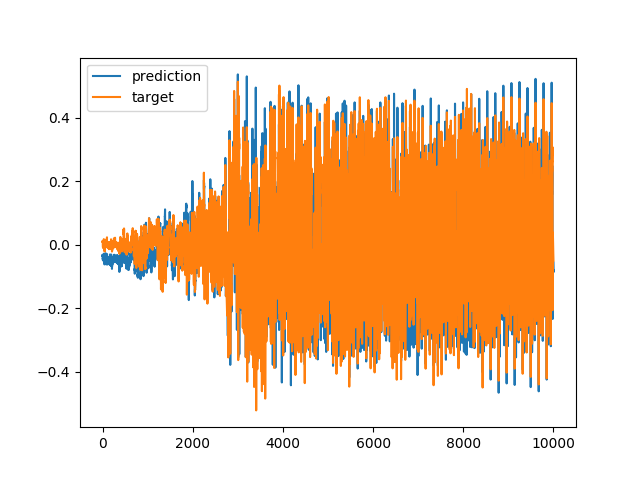

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)